In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ver = 'v40_cerberus'
ab = 'TPM_allGene.tsv'
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/'


In [3]:
df = pd.read_csv(ab, sep='\t')
df, gids = get_tpm_table(df,
                 how='sr',
                 min_tpm=1,
                 gene_subset='polya')
df = df.transpose()
print(df.shape)

Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 36716
Applying gene type subset
Number of genes reported: 33297
(510, 33297)


In [4]:
X = df.values
print(X.shape)
print(len(df.index))
print(len(df.columns))

# obs table w/ sample info
# TODO replace w/ add_sample_to_sr
obs = df.index.to_frame()
obs.rename({0: 'dataset'}, axis=1, inplace=True)
obs['biosample'] = obs.dataset.str.rsplit('_', n=2, expand=True)[0]
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
print()
print(len(obs.index))
obs = obs.merge(tissue_df, how='left', on='biosample')
print(len(obs.index))
print()
obs.loc[obs.tissue.isnull(), 'tissue'] = obs.loc[obs.tissue.isnull(), 'biosample']
obs.drop('biosample', axis=1, inplace=True)
obs.rename({'tissue': 'sample'}, axis=1, inplace=True)
obs['sample'].unique()
print(obs.loc[obs['dataset'].str.contains('mcf7')])

# var
var = pd.DataFrame(data=df.columns.tolist(), columns=['gid'])
var.head()

adata = anndata.AnnData(obs=obs, var=var, X=X)

(510, 33297)
510
33297

510
510

      dataset sample
411  mcf7_1_1   mcf7


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.obs.head()

,dataset,sample
0,activated_cd4_positive_alpha_beta_t_cell_2_1,activated_cd4_positive_alpha_beta_t_cell
1,cd4_positive_alpha_beta_t_cell_1_1,cd4_positive_alpha_beta_t_cell
2,activated_cd8_positive_alpha_beta_memory_t_cel...,activated_cd8_positive_alpha_beta_memory_t_cell
3,cd8_positive_alpha_beta_memory_t_cell_1_1,cd8_positive_alpha_beta_memory_t_cell
4,naive_thymus_derived_cd4_positive_alpha_beta_t...,naive_thymus_derived_cd4_positive_alpha_beta_t...


In [6]:
# limit only to samples that are in the long-read
c_dict, order = get_biosample_colors()
adata = adata[adata.obs['sample'].isin(order)]
adata

View of AnnData object with n_obs × n_vars = 236 × 33297
    obs: 'dataset', 'sample'
    var: 'gid'

In [7]:
# add colors
# map values in order specific to
obs_col = 'sample'
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

Trying to set attribute `.obs` of view, copying.


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', pleas

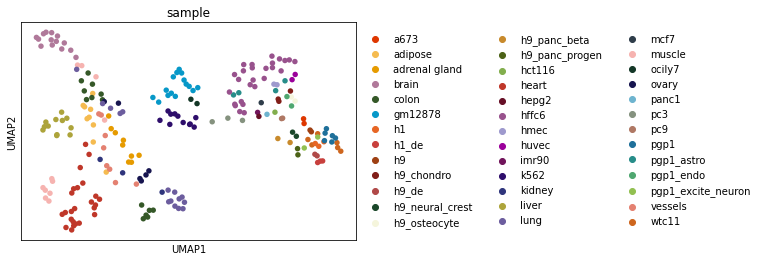

In [8]:
len(adata.var.index)

# # normalize data matrix to 10,000 count
# sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 12000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, use_highly_variable=False)
# sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/sr_umap.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'sr_umap.pdf', dpi=500, bbox_inches='tight')


In [19]:
adata.obs.loc[adata.obs['sample']=='hffc6']

,dataset,sample
77,hffc6_1_1,hffc6
78,hffc6_1_2,hffc6
79,hffc6_1_3,hffc6
80,hffc6_1_4,hffc6
81,hffc6_1_5,hffc6
82,hffc6_1_6,hffc6
182,hffc6_4_1,hffc6
183,hffc6_4_2,hffc6
184,hffc6_4_3,hffc6
185,hffc6_4_4,hffc6
